In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import warnings

warnings.filterwarnings("ignore")

# === Загрузка и предобработка файла ALRS ===
alrs_raw = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/alrs_candles.csv")
alrs = alrs_raw[["begin", "close"]].copy()
alrs["Date"] = pd.to_datetime(alrs["begin"]).dt.date
alrs = alrs.rename(columns={"close": "Stock Close"}).drop(columns=["begin"])
alrs = alrs.groupby("Date").first().reset_index()
alrs["Date"] = pd.to_datetime(alrs["Date"])
alrs.set_index("Date", inplace=True)

# === Функции ===
def load_and_prepare(file_path, date_col, value_col, skip_rows=0, date_format=None):
    df = pd.read_csv(file_path, skiprows=skip_rows)
    df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[[value_col]]

def process_non_standard_file(file_path, date_col, value_col):
    df = pd.read_csv(file_path, skiprows=2)
    df.columns = [date_col, value_col, 'High', 'Low', 'Open', 'Volume']
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[[value_col]]

def process_vix_file(file_path):
    df = pd.read_csv(file_path, skiprows=2)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df.set_index('Date', inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[['Close']].rename(columns={'Close': 'VIX'})

# === Пути к данным ===
file_paths = {
    "imoex": "C:/Users/Matvey/Desktop/Диплом/imoex_candles.csv",
    "rtsi": "C:/Users/Matvey/Desktop/Диплом/rtsi_candles.csv",
    "vix": "C:/Users/Matvey/Desktop/Диплом/vix_data.csv",
    "gvz": "C:/Users/Matvey/Desktop/Диплом/gvz_data.csv",
    "gold": "C:/Users/Matvey/Desktop/Диплом/gold_data.csv",
    "oil": "C:/Users/Matvey/Desktop/Диплом/oil_data.csv",
    "moexog": "C:/Users/Matvey/Desktop/Диплом/moexog_candles.csv",
    "rgbi": "C:/Users/Matvey/Desktop/Диплом/rgbi_candles.csv",
    "macro": "C:/Users/Matvey/Desktop/Диплом/macroeconomic_data.csv"
}

# === Загрузка экзогенных переменных ===
imoex = load_and_prepare(file_paths["imoex"], "begin", "close").rename(columns={"close": "IMOEX Close"})
rtsi = load_and_prepare(file_paths["rtsi"], "begin", "close").rename(columns={"close": "RTSI Close"})
moexog = load_and_prepare(file_paths["moexog"], "begin", "close").rename(columns={"close": "MOEXOG Close"})
rgbi = load_and_prepare(file_paths["rgbi"], "begin", "close").rename(columns={"close": "RGBI Close"})
vix = process_vix_file(file_paths["vix"])
gvz = process_non_standard_file(file_paths["gvz"], "Date", "Close").rename(columns={"Close": "GVZ"})
gold = process_non_standard_file(file_paths["gold"], "Date", "Close").rename(columns={"Close": "Gold Price"})
oil = process_non_standard_file(file_paths["oil"], "Date", "Close").rename(columns={"Close": "Oil Price"})

# === Макроэкономика ===
macro_df = pd.read_csv(file_paths["macro"])
macro_df['date'] = pd.to_datetime(macro_df['date'], errors='coerce')
macro_df = macro_df.dropna(subset=['date'])
macro_df.set_index('date', inplace=True)
macro_df = macro_df[~macro_df.index.duplicated(keep='first')]
macro_df = macro_df[['inflation', 'key_rate', 'usd_rate', 'cny_rate']]
macro_df.columns = ['Inflation', 'Key Rate', 'USD Rate', 'CNY Rate']
macro_df = macro_df.resample('D').interpolate()

# === Объединение всех данных ===
merged_data = pd.concat(
    [alrs, imoex, rtsi, moexog, rgbi, vix, gvz, gold, oil, macro_df],
    axis=1
)

# === Заполнение пропусков ===
merged_data = merged_data.interpolate(method='linear')
merged_data = merged_data[::-1].ffill()[::-1]

# === Сброс индекса и сохранение с колонкой "Date" ===
merged_data = merged_data.reset_index().rename(columns={"index": "Date"})
output_path = "C:/Users/Matvey/Desktop/Диплом/alrs_merged_data.csv"
merged_data.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"✅ Данные успешно сохранены в: {output_path}")

# Просмотр первых строк
display(merged_data.head())


✅ Данные успешно сохранены в: C:/Users/Matvey/Desktop/Диплом/alrs_merged_data.csv


,Date,Stock Close,IMOEX Close,RTSI Close,MOEXOG Close,RGBI Close,VIX,GVZ,Gold Price,Oil Price,Inflation,Key Rate,USD Rate,CNY Rate
0,2015-01-01,98.73,1435.66,761.3,3640.27,104.98,17.790001,20.230000,1186.000000,56.419998,68.368100,56.237600,60.85,10.916
1,2015-01-02,98.73,1435.66,761.3,3640.27,104.98,17.790001,20.230000,1186.000000,56.419998,68.867017,56.779158,60.85,10.916
2,2015-01-03,98.73,1435.66,761.3,3640.27,104.98,18.500001,20.573333,1191.966675,55.316666,69.365933,57.320717,60.85,10.916
3,2015-01-04,98.73,1435.66,761.3,3640.27,104.98,19.210000,20.916667,1197.933350,54.213333,69.864850,57.862275,60.85,10.916
4,2015-01-05,98.73,1435.66,761.3,3640.27,104.98,19.920000,21.260000,1203.900024,53.110001,70.363767,58.403833,60.85,10.916


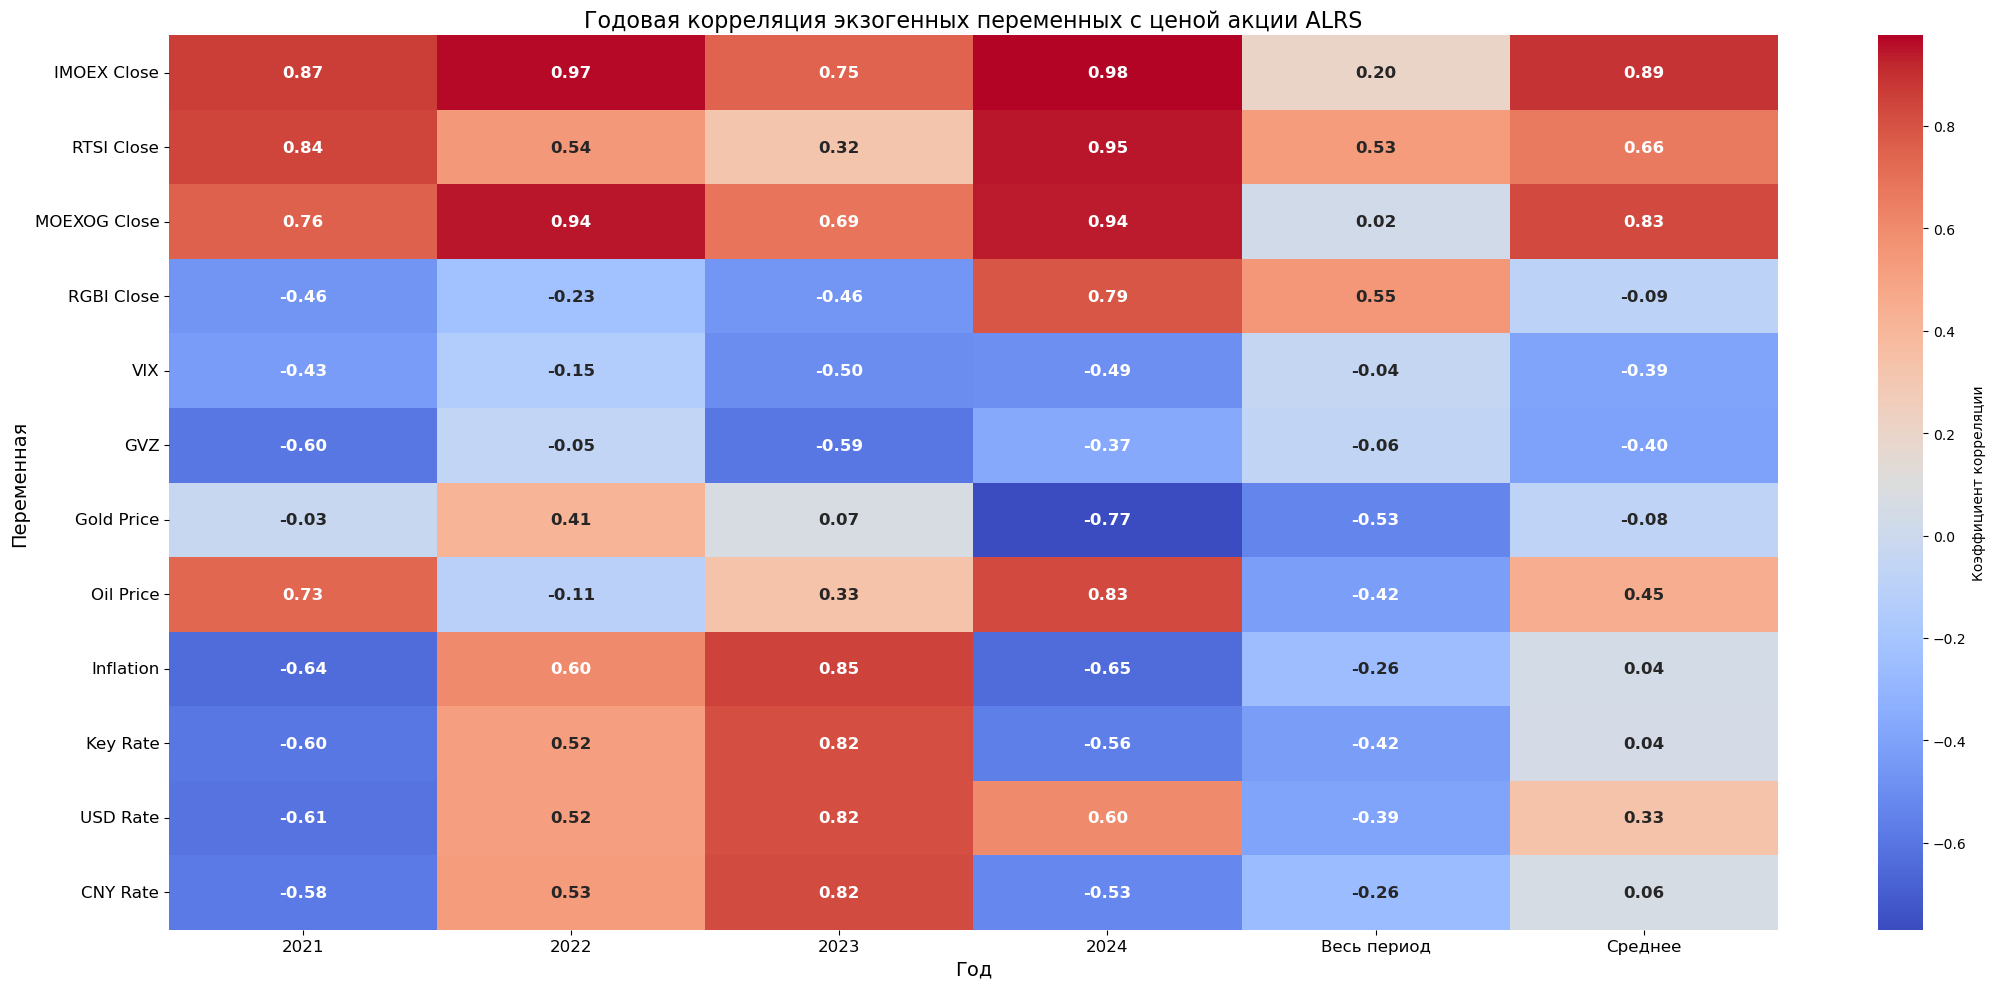

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Загрузка объединённых данных ===
merged_data = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/alrs_merged_data.csv")
merged_data["Date"] = pd.to_datetime(merged_data["Date"])
merged_data.set_index("Date", inplace=True)


# --- 2. Годовые корреляции с 'Stock Close' по всем годам + Весь период + Среднее ---
years = range(2021, 2025)
yearly_corrs = {}

for year in years:
    yearly_df = merged_data[merged_data.index.year == year]
    if not yearly_df.empty:
        corr = yearly_df.corr(numeric_only=True)
        yearly_corrs[str(year)] = corr["Stock Close"].drop("Stock Close", errors="ignore")

# Корреляции за весь период
corr_all_period = merged_data.corr(numeric_only=True)["Stock Close"].drop("Stock Close", errors="ignore")
yearly_corrs["Весь период"] = corr_all_period

# Сводная таблица
corr_by_year_df = pd.DataFrame(yearly_corrs)
years_only = [str(year) for year in years if str(year) in corr_by_year_df.columns]
corr_by_year_df["Среднее"] = corr_by_year_df[years_only].mean(axis=1)

# --- Визуализация ---
plt.figure(figsize=(22, 10))
sns.heatmap(
    corr_by_year_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar_kws={'label': 'Коэффициент корреляции'},
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title("Годовая корреляция экзогенных переменных с ценой акции ALRS", fontsize=16)
plt.xlabel("Год", fontsize=14)
plt.ylabel("Переменная", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Вернуть Date обратно в колонку
merged_data.reset_index(inplace=True)


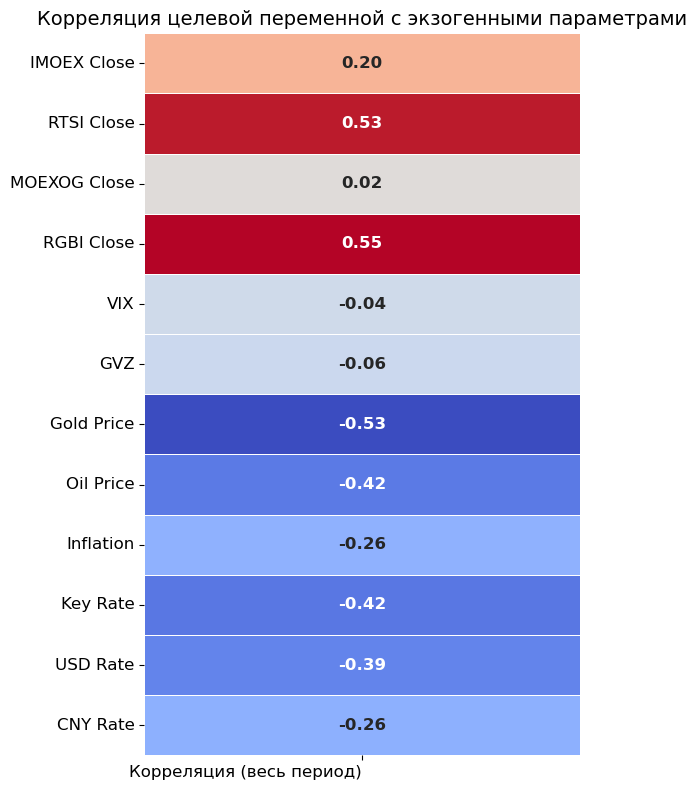

In [3]:
# Убираем колонку Date из данных для расчёта корреляций
data_for_corr = merged_data.drop(columns=["Date"], errors="ignore")

# Пересчёт корреляций только для всего периода
corr_all_period = data_for_corr.corr()["Stock Close"].drop("Stock Close", errors="ignore")

# Приведение к DataFrame для тепловой карты
corr_df = pd.DataFrame(corr_all_period)
corr_df.columns = ["Корреляция (весь период)"]

# Построение тепловой карты
plt.figure(figsize=(6, 8))
sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title("Корреляция целевой переменной с экзогенными параметрами", fontsize=14)
plt.xticks(fontsize=12, ha='right')  # Наклон 45° и выравнивание вправо
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


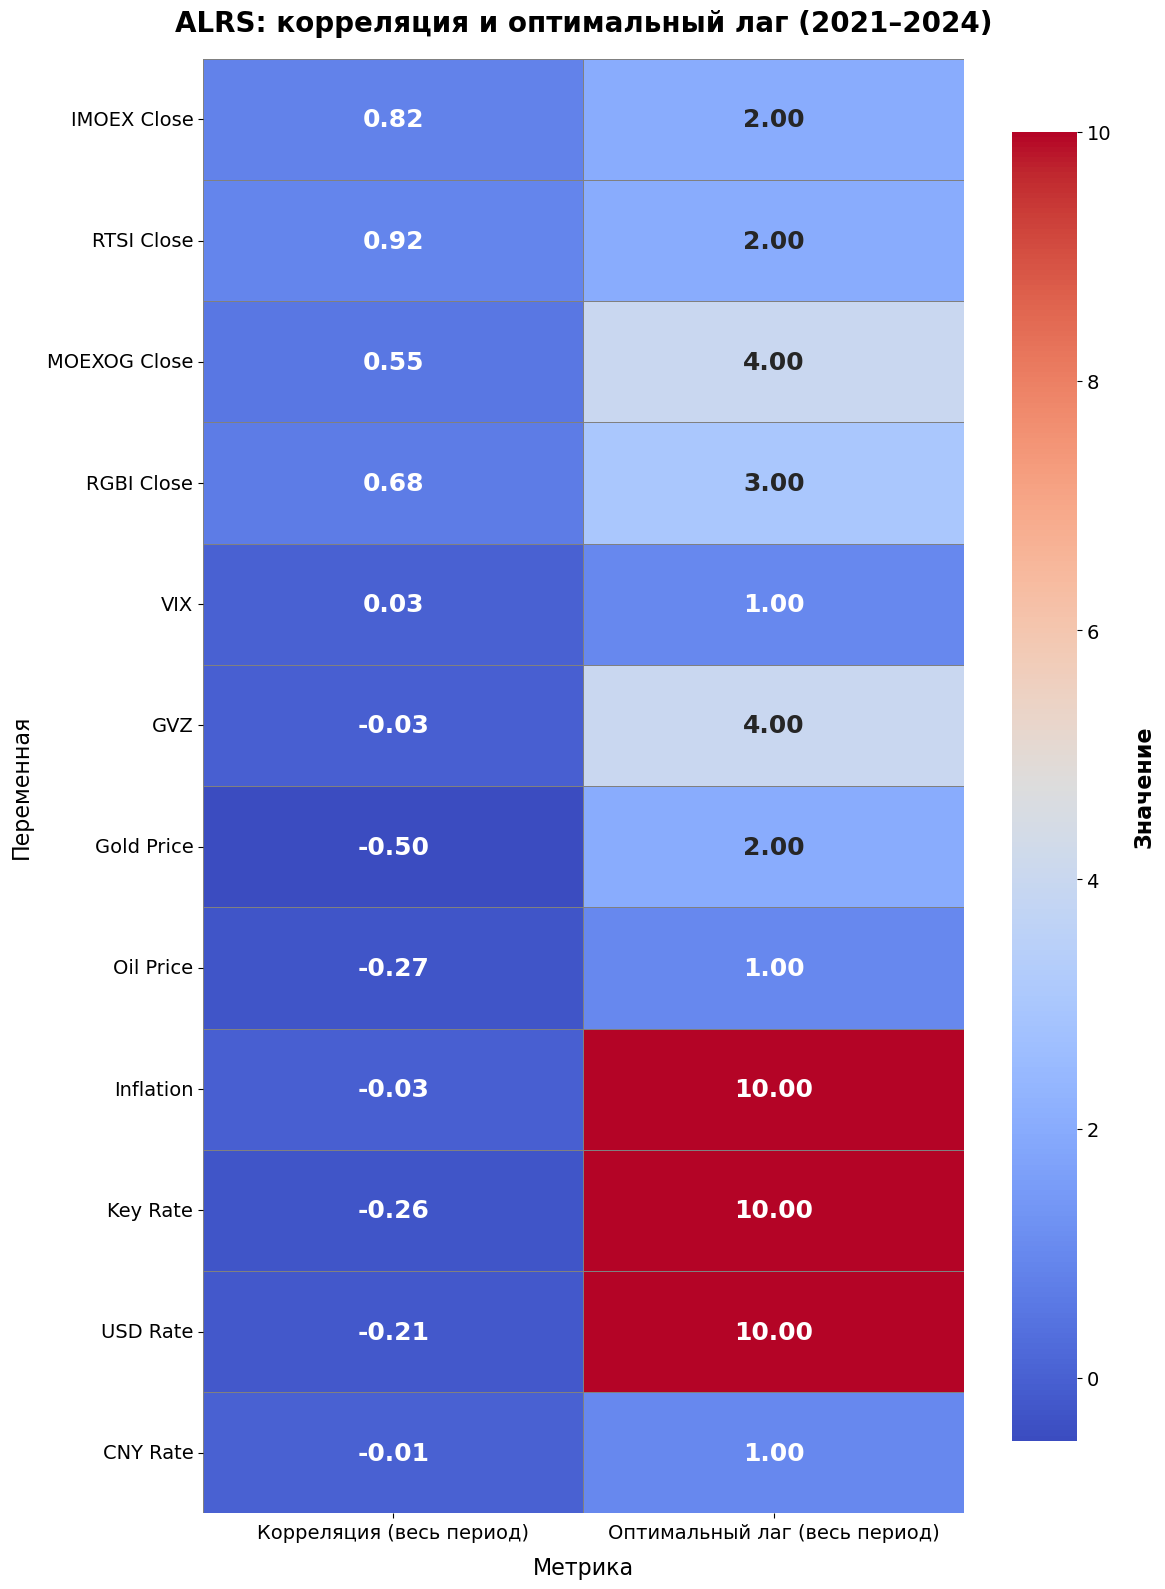

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
import warnings

warnings.filterwarnings('ignore')

# === Загрузка и подготовка данных ===
df = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/alrs_merged_data.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]  # Удаляем константные столбцы

# === Настройка переменных ===
target = 'Stock Close'
best_features = [col for col in df.columns if col != target]

# === Интерполяция и очистка ===
df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

# === Годовые корреляции ===
years = [2021, 2022, 2023, 2024]
corr_by_year = {}

for year in years:
    df_year = df[df.index.year == year]
    corr = df_year.corr()
    corr_by_year[str(year)] = corr[target].drop(target)

# === Корреляция за весь период ===
corr_total = df.corr()
corr_by_year["Весь период"] = corr_total[target].drop(target)

# === Таблица корреляций по годам ===
corr_by_year_df = pd.DataFrame(corr_by_year)

# === Расчёт оптимальных лагов (Грейнджер) ===
lags_total = {}
for feature in best_features:
    try:
        test_result = grangercausalitytests(df[[target, feature]].dropna(), maxlag=10, verbose=False)
        p_values = [test_result[i+1][0]['ssr_ftest'][1] for i in range(10)]
        optimal_lag = np.argmin(p_values) + 1
        lags_total[feature] = optimal_lag
    except Exception:
        lags_total[feature] = np.nan

lags_total_series = pd.Series(lags_total, name="Оптимальный лаг (весь период)")
corr_total_series = corr_by_year_df["Весь период"]

# === Итоговая таблица ARIMAX-анализа ===
arimax_total_selection = pd.concat([corr_total_series, lags_total_series], axis=1)
arimax_total_selection.columns = ["Корреляция (весь период)", "Оптимальный лаг (весь период)"]

# === Визуализация тепловой карты ===
plt.figure(figsize=(12, 16))

heatmap = sns.heatmap(
    arimax_total_selection,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.6,
    linecolor="gray",
    annot_kws={"size": 18, "weight": "bold"},
    cbar_kws={"label": "Значение", "shrink": 0.9}
)

plt.title("ALRS: корреляция и оптимальный лаг (2021–2024)", fontsize=20, fontweight="bold", pad=20)
plt.xlabel("Метрика", fontsize=16, labelpad=10)
plt.ylabel("Переменная", fontsize=16, labelpad=10)

plt.xticks(fontsize=14, rotation=0)
plt.yticks(fontsize=14, rotation=0)
plt.subplots_adjust(left=0.3)

colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label("Значение", fontsize=16, weight="bold", labelpad=15)

plt.tight_layout()
plt.show()


🔄 Rolling forecast начат...


Прогнозирование:   0%|                                                                        | 0/364 [00:00<?, ?шаг/s]

📍 Итерация 0-1 | Дата: 2024-01-02


Прогнозирование:   0%|▏                                                               | 1/364 [00:04<26:40,  4.41s/шаг]

📍 Итерация 1-2 | Дата: 2024-01-03


Прогнозирование:   1%|▎                                                               | 2/364 [00:09<29:05,  4.82s/шаг]

📍 Итерация 2-3 | Дата: 2024-01-04


Прогнозирование:   1%|▌                                                               | 3/364 [00:13<26:46,  4.45s/шаг]

📍 Итерация 3-4 | Дата: 2024-01-05


Прогнозирование:   1%|▋                                                               | 4/364 [00:17<26:39,  4.44s/шаг]

📍 Итерация 4-5 | Дата: 2024-01-06


Прогнозирование:   1%|▉                                                               | 5/364 [00:22<25:45,  4.30s/шаг]

📍 Итерация 5-6 | Дата: 2024-01-07


Прогнозирование:   2%|█                                                               | 6/364 [00:26<25:11,  4.22s/шаг]

📍 Итерация 6-7 | Дата: 2024-01-08


Прогнозирование:   2%|█▏                                                              | 7/364 [00:31<26:39,  4.48s/шаг]

📍 Итерация 7-8 | Дата: 2024-01-09


Прогнозирование:   2%|█▍                                                              | 8/364 [00:35<25:30,  4.30s/шаг]

📍 Итерация 8-9 | Дата: 2024-01-10


Прогнозирование:   2%|█▌                                                              | 9/364 [00:38<24:48,  4.19s/шаг]

📍 Итерация 9-10 | Дата: 2024-01-11


Прогнозирование:   3%|█▋                                                             | 10/364 [00:44<26:21,  4.47s/шаг]

📍 Итерация 10-11 | Дата: 2024-01-12


Прогнозирование:   3%|█▉                                                             | 11/364 [00:48<26:35,  4.52s/шаг]

📍 Итерация 11-12 | Дата: 2024-01-13


Прогнозирование:   3%|██                                                             | 12/364 [00:52<26:06,  4.45s/шаг]

📍 Итерация 12-13 | Дата: 2024-01-14


Прогнозирование:   4%|██▎                                                            | 13/364 [00:56<24:51,  4.25s/шаг]

📍 Итерация 13-14 | Дата: 2024-01-15


Прогнозирование:   4%|██▍                                                            | 14/364 [01:00<24:11,  4.15s/шаг]

📍 Итерация 14-15 | Дата: 2024-01-16


Прогнозирование:   4%|██▌                                                            | 15/364 [01:05<25:21,  4.36s/шаг]

📍 Итерация 15-16 | Дата: 2024-01-17


Прогнозирование:   4%|██▊                                                            | 16/364 [01:09<25:28,  4.39s/шаг]

📍 Итерация 16-17 | Дата: 2024-01-18


Прогнозирование:   5%|██▉                                                            | 17/364 [01:14<26:03,  4.51s/шаг]

📍 Итерация 17-18 | Дата: 2024-01-19


Прогнозирование:   5%|███                                                            | 18/364 [01:18<25:01,  4.34s/шаг]

📍 Итерация 18-19 | Дата: 2024-01-20


Прогнозирование:   5%|███▎                                                           | 19/364 [01:23<25:19,  4.40s/шаг]

📍 Итерация 19-20 | Дата: 2024-01-21


Прогнозирование:   5%|███▍                                                           | 20/364 [01:27<25:07,  4.38s/шаг]

📍 Итерация 20-21 | Дата: 2024-01-22


Прогнозирование:   6%|███▋                                                           | 21/364 [01:31<24:58,  4.37s/шаг]

📍 Итерация 21-22 | Дата: 2024-01-23


Прогнозирование:   6%|███▊                                                           | 22/364 [01:36<24:42,  4.33s/шаг]

📍 Итерация 22-23 | Дата: 2024-01-24


Прогнозирование:   6%|███▉                                                           | 23/364 [01:40<23:48,  4.19s/шаг]

📍 Итерация 23-24 | Дата: 2024-01-25


Прогнозирование:   7%|████▏                                                          | 24/364 [01:44<24:07,  4.26s/шаг]

📍 Итерация 24-25 | Дата: 2024-01-26


Прогнозирование:   7%|████▎                                                          | 25/364 [01:48<23:47,  4.21s/шаг]

📍 Итерация 25-26 | Дата: 2024-01-27


Прогнозирование:   7%|████▌                                                          | 26/364 [01:52<23:40,  4.20s/шаг]

📍 Итерация 26-27 | Дата: 2024-01-28


Прогнозирование:   7%|████▋                                                          | 27/364 [01:56<23:36,  4.20s/шаг]

📍 Итерация 27-28 | Дата: 2024-01-29


Прогнозирование:   8%|████▊                                                          | 28/364 [02:01<24:12,  4.32s/шаг]

📍 Итерация 28-29 | Дата: 2024-01-30


Прогнозирование:   8%|█████                                                          | 29/364 [02:06<24:44,  4.43s/шаг]

📍 Итерация 29-30 | Дата: 2024-01-31


Прогнозирование:   8%|█████▏                                                         | 30/364 [02:09<23:04,  4.14s/шаг]

📍 Итерация 30-31 | Дата: 2024-02-01


Прогнозирование:   9%|█████▎                                                         | 31/364 [02:13<22:56,  4.13s/шаг]

📍 Итерация 31-32 | Дата: 2024-02-02


Прогнозирование:   9%|█████▌                                                         | 32/364 [02:18<24:13,  4.38s/шаг]

📍 Итерация 32-33 | Дата: 2024-02-03


Прогнозирование:   9%|█████▋                                                         | 33/364 [02:24<25:43,  4.66s/шаг]

📍 Итерация 33-34 | Дата: 2024-02-04


Прогнозирование:   9%|█████▉                                                         | 34/364 [02:28<24:50,  4.52s/шаг]

📍 Итерация 34-35 | Дата: 2024-02-05


Прогнозирование:  10%|██████                                                         | 35/364 [02:32<24:26,  4.46s/шаг]

📍 Итерация 35-36 | Дата: 2024-02-06


Прогнозирование:  10%|██████▏                                                        | 36/364 [02:37<24:57,  4.56s/шаг]

📍 Итерация 36-37 | Дата: 2024-02-07


Прогнозирование:  10%|██████▍                                                        | 37/364 [02:42<25:55,  4.76s/шаг]

📍 Итерация 37-38 | Дата: 2024-02-08


Прогнозирование:  10%|██████▌                                                        | 38/364 [02:47<25:19,  4.66s/шаг]

📍 Итерация 38-39 | Дата: 2024-02-09


Прогнозирование:  11%|██████▊                                                        | 39/364 [02:51<24:43,  4.56s/шаг]

📍 Итерация 39-40 | Дата: 2024-02-10


Прогнозирование:  11%|██████▉                                                        | 40/364 [02:56<25:29,  4.72s/шаг]

📍 Итерация 40-41 | Дата: 2024-02-11


Прогнозирование:  11%|███████                                                        | 41/364 [03:01<25:11,  4.68s/шаг]

📍 Итерация 41-42 | Дата: 2024-02-12


Прогнозирование:  12%|███████▎                                                       | 42/364 [03:05<24:06,  4.49s/шаг]

📍 Итерация 42-43 | Дата: 2024-02-13


Прогнозирование:  12%|███████▍                                                       | 43/364 [03:11<26:32,  4.96s/шаг]

📍 Итерация 43-44 | Дата: 2024-02-14


Прогнозирование:  12%|███████▌                                                       | 44/364 [03:16<27:46,  5.21s/шаг]

📍 Итерация 44-45 | Дата: 2024-02-15


Прогнозирование:  12%|███████▊                                                       | 45/364 [03:22<27:29,  5.17s/шаг]

📍 Итерация 45-46 | Дата: 2024-02-16


Прогнозирование:  13%|███████▉                                                       | 46/364 [03:27<28:11,  5.32s/шаг]

📍 Итерация 46-47 | Дата: 2024-02-17


Прогнозирование:  13%|████████▏                                                      | 47/364 [03:32<26:42,  5.06s/шаг]

📍 Итерация 47-48 | Дата: 2024-02-18


Прогнозирование:  13%|████████▎                                                      | 48/364 [03:37<27:24,  5.20s/шаг]

📍 Итерация 48-49 | Дата: 2024-02-19


Прогнозирование:  13%|████████▍                                                      | 49/364 [03:42<26:21,  5.02s/шаг]

📍 Итерация 49-50 | Дата: 2024-02-20


Прогнозирование:  14%|████████▋                                                      | 50/364 [03:47<27:00,  5.16s/шаг]

📍 Итерация 50-51 | Дата: 2024-02-21


Прогнозирование:  14%|████████▊                                                      | 51/364 [04:00<38:55,  7.46s/шаг]

📍 Итерация 51-52 | Дата: 2024-02-22


Прогнозирование:  14%|█████████                                                      | 52/364 [04:15<50:43,  9.75s/шаг]

📍 Итерация 52-53 | Дата: 2024-02-23


Прогнозирование:  15%|█████████▏                                                     | 53/364 [04:30<59:06, 11.41s/шаг]

📍 Итерация 53-54 | Дата: 2024-02-24


Прогнозирование:  15%|█████████                                                    | 54/364 [04:43<1:01:15, 11.86s/шаг]

📍 Итерация 54-55 | Дата: 2024-02-25


Прогнозирование:  15%|█████████▏                                                   | 55/364 [04:56<1:01:48, 12.00s/шаг]

📍 Итерация 55-56 | Дата: 2024-02-26


Прогнозирование:  15%|█████████▍                                                   | 56/364 [05:08<1:02:20, 12.14s/шаг]

📍 Итерация 56-57 | Дата: 2024-02-27


Прогнозирование:  16%|█████████▌                                                   | 57/364 [05:20<1:02:14, 12.16s/шаг]

📍 Итерация 57-58 | Дата: 2024-02-28


Прогнозирование:  16%|██████████                                                     | 58/364 [05:24<49:11,  9.64s/шаг]

📍 Итерация 58-59 | Дата: 2024-02-29


Прогнозирование:  16%|██████████▏                                                    | 59/364 [05:28<40:19,  7.93s/шаг]

📍 Итерация 59-60 | Дата: 2024-03-01


Прогнозирование:  16%|██████████▍                                                    | 60/364 [05:40<46:03,  9.09s/шаг]

📍 Итерация 60-61 | Дата: 2024-03-02


Прогнозирование:  17%|██████████▌                                                    | 61/364 [05:44<38:30,  7.63s/шаг]

📍 Итерация 61-62 | Дата: 2024-03-03


Прогнозирование:  17%|██████████▋                                                    | 62/364 [05:48<32:38,  6.49s/шаг]

📍 Итерация 62-63 | Дата: 2024-03-04


Прогнозирование:  17%|██████████▉                                                    | 63/364 [05:52<29:12,  5.82s/шаг]

📍 Итерация 63-64 | Дата: 2024-03-05


Прогнозирование:  18%|███████████                                                    | 64/364 [05:56<25:58,  5.20s/шаг]

📍 Итерация 64-65 | Дата: 2024-03-06


Прогнозирование:  18%|███████████▎                                                   | 65/364 [06:00<23:46,  4.77s/шаг]

📍 Итерация 65-66 | Дата: 2024-03-07


Прогнозирование:  18%|███████████▍                                                   | 66/364 [06:04<23:38,  4.76s/шаг]

📍 Итерация 66-67 | Дата: 2024-03-08


Прогнозирование:  18%|███████████▌                                                   | 67/364 [06:08<22:02,  4.45s/шаг]

📍 Итерация 67-68 | Дата: 2024-03-09


Прогнозирование:  19%|███████████▊                                                   | 68/364 [06:13<22:14,  4.51s/шаг]

📍 Итерация 68-69 | Дата: 2024-03-10


Прогнозирование:  19%|███████████▉                                                   | 69/364 [06:16<20:56,  4.26s/шаг]

📍 Итерация 69-70 | Дата: 2024-03-11


Прогнозирование:  19%|████████████                                                   | 70/364 [06:21<20:50,  4.25s/шаг]

📍 Итерация 70-71 | Дата: 2024-03-12


Прогнозирование:  20%|████████████▎                                                  | 71/364 [06:25<20:28,  4.19s/шаг]

📍 Итерация 71-72 | Дата: 2024-03-13


Прогнозирование:  20%|████████████▍                                                  | 72/364 [06:28<19:23,  3.98s/шаг]

📍 Итерация 72-73 | Дата: 2024-03-14


Прогнозирование:  20%|████████████▋                                                  | 73/364 [06:33<19:42,  4.06s/шаг]

📍 Итерация 73-74 | Дата: 2024-03-15


Прогнозирование:  20%|████████████▊                                                  | 74/364 [06:36<19:06,  3.95s/шаг]

📍 Итерация 74-75 | Дата: 2024-03-16


Прогнозирование:  21%|████████████▉                                                  | 75/364 [06:40<18:49,  3.91s/шаг]

📍 Итерация 75-76 | Дата: 2024-03-17


Прогнозирование:  21%|█████████████▏                                                 | 76/364 [06:44<18:54,  3.94s/шаг]

📍 Итерация 76-77 | Дата: 2024-03-18


Прогнозирование:  21%|█████████████▎                                                 | 77/364 [06:48<19:02,  3.98s/шаг]

📍 Итерация 77-78 | Дата: 2024-03-19


Прогнозирование:  21%|█████████████▌                                                 | 78/364 [06:52<18:40,  3.92s/шаг]

📍 Итерация 78-79 | Дата: 2024-03-20


Прогнозирование:  22%|█████████████▋                                                 | 79/364 [07:05<32:21,  6.81s/шаг]

📍 Итерация 79-80 | Дата: 2024-03-21


Прогнозирование:  22%|█████████████▊                                                 | 80/364 [07:21<44:00,  9.30s/шаг]

📍 Итерация 80-81 | Дата: 2024-03-22


Прогнозирование:  22%|██████████████                                                 | 81/364 [07:34<49:24, 10.48s/шаг]

📍 Итерация 81-82 | Дата: 2024-03-23


Прогнозирование:  23%|██████████████▏                                                | 82/364 [07:48<54:22, 11.57s/шаг]

📍 Итерация 82-83 | Дата: 2024-03-24


Прогнозирование:  23%|██████████████▎                                                | 83/364 [08:00<54:13, 11.58s/шаг]

📍 Итерация 83-84 | Дата: 2024-03-25


Прогнозирование:  23%|██████████████▌                                                | 84/364 [08:12<55:30, 11.89s/шаг]

📍 Итерация 84-85 | Дата: 2024-03-26


Прогнозирование:  23%|██████████████▋                                                | 85/364 [08:27<59:47, 12.86s/шаг]

📍 Итерация 85-86 | Дата: 2024-03-27


Прогнозирование:  24%|██████████████▍                                              | 86/364 [08:41<1:00:20, 13.02s/шаг]

📍 Итерация 86-87 | Дата: 2024-03-28


Прогнозирование:  24%|███████████████                                                | 87/364 [08:53<58:42, 12.72s/шаг]

📍 Итерация 87-88 | Дата: 2024-03-29


Прогнозирование:  24%|███████████████▏                                               | 88/364 [09:05<57:32, 12.51s/шаг]

📍 Итерация 88-89 | Дата: 2024-03-30


Прогнозирование:  24%|███████████████▍                                               | 89/364 [09:16<55:58, 12.21s/шаг]

📍 Итерация 89-90 | Дата: 2024-03-31


Прогнозирование:  25%|███████████████▌                                               | 90/364 [09:30<58:28, 12.80s/шаг]

📍 Итерация 90-91 | Дата: 2024-04-01


Прогнозирование:  25%|███████████████▊                                               | 91/364 [09:42<57:09, 12.56s/шаг]

📍 Итерация 91-92 | Дата: 2024-04-02


Прогнозирование:  25%|███████████████▉                                               | 92/364 [09:54<56:11, 12.40s/шаг]

📍 Итерация 92-93 | Дата: 2024-04-03


Прогнозирование:  26%|███████████████▌                                             | 93/364 [10:10<1:00:11, 13.33s/шаг]

📍 Итерация 93-94 | Дата: 2024-04-04


Прогнозирование:  26%|███████████████▊                                             | 94/364 [10:25<1:01:51, 13.75s/шаг]

📍 Итерация 94-95 | Дата: 2024-04-05


Прогнозирование:  26%|███████████████▉                                             | 95/364 [10:38<1:00:58, 13.60s/шаг]

📍 Итерация 95-96 | Дата: 2024-04-06


Прогнозирование:  26%|████████████████                                             | 96/364 [10:53<1:03:16, 14.17s/шаг]

📍 Итерация 96-97 | Дата: 2024-04-07


Прогнозирование:  27%|████████████████▎                                            | 97/364 [11:08<1:03:06, 14.18s/шаг]

📍 Итерация 97-98 | Дата: 2024-04-08


Прогнозирование:  27%|████████████████▍                                            | 98/364 [11:23<1:04:10, 14.48s/шаг]

📍 Итерация 98-99 | Дата: 2024-04-09


Прогнозирование:  27%|████████████████▌                                            | 99/364 [11:38<1:04:32, 14.61s/шаг]

📍 Итерация 99-100 | Дата: 2024-04-10


Прогнозирование:  27%|████████████████▍                                           | 100/364 [11:52<1:03:37, 14.46s/шаг]

📍 Итерация 100-101 | Дата: 2024-04-11


Прогнозирование:  28%|████████████████▋                                           | 101/364 [12:05<1:02:23, 14.23s/шаг]

📍 Итерация 101-102 | Дата: 2024-04-12


Прогнозирование:  28%|████████████████▊                                           | 102/364 [12:20<1:02:15, 14.26s/шаг]

📍 Итерация 102-103 | Дата: 2024-04-13


Прогнозирование:  28%|████████████████▉                                           | 103/364 [12:33<1:00:55, 14.00s/шаг]

📍 Итерация 103-104 | Дата: 2024-04-14


Прогнозирование:  29%|█████████████████▏                                          | 104/364 [12:47<1:00:31, 13.97s/шаг]

📍 Итерация 104-105 | Дата: 2024-04-15


Прогнозирование:  29%|█████████████████▉                                            | 105/364 [13:01<59:55, 13.88s/шаг]

📍 Итерация 105-106 | Дата: 2024-04-16


Прогнозирование:  29%|██████████████████                                            | 106/364 [13:14<59:12, 13.77s/шаг]

📍 Итерация 106-107 | Дата: 2024-04-17


Прогнозирование:  29%|██████████████████▏                                           | 107/364 [13:28<58:29, 13.65s/шаг]

📍 Итерация 107-108 | Дата: 2024-04-18


Прогнозирование:  30%|██████████████████▍                                           | 108/364 [13:41<57:52, 13.57s/шаг]

📍 Итерация 108-109 | Дата: 2024-04-19


Прогнозирование:  30%|██████████████████▌                                           | 109/364 [13:55<57:40, 13.57s/шаг]

📍 Итерация 109-110 | Дата: 2024-04-20


Прогнозирование:  30%|██████████████████▋                                           | 110/364 [14:08<57:47, 13.65s/шаг]

📍 Итерация 110-111 | Дата: 2024-04-21


Прогнозирование:  30%|██████████████████▉                                           | 111/364 [14:22<57:35, 13.66s/шаг]

📍 Итерация 111-112 | Дата: 2024-04-22


Прогнозирование:  31%|███████████████████                                           | 112/364 [14:36<58:07, 13.84s/шаг]

📍 Итерация 112-113 | Дата: 2024-04-23


Прогнозирование:  31%|██████████████████▋                                         | 113/364 [14:52<1:00:14, 14.40s/шаг]

📍 Итерация 113-114 | Дата: 2024-04-24


Прогнозирование:  31%|██████████████████▊                                         | 114/364 [15:07<1:01:00, 14.64s/шаг]

📍 Итерация 114-115 | Дата: 2024-04-25


Прогнозирование:  32%|██████████████████▉                                         | 115/364 [15:23<1:01:55, 14.92s/шаг]

📍 Итерация 115-116 | Дата: 2024-04-26


Прогнозирование:  32%|███████████████████                                         | 116/364 [15:38<1:01:26, 14.86s/шаг]

📍 Итерация 116-117 | Дата: 2024-04-27


Прогнозирование:  32%|███████████████████▎                                        | 117/364 [15:52<1:00:50, 14.78s/шаг]

📍 Итерация 117-118 | Дата: 2024-04-28


Прогнозирование:  32%|███████████████████▍                                        | 118/364 [16:07<1:00:22, 14.73s/шаг]

📍 Итерация 118-119 | Дата: 2024-04-29


Прогнозирование:  33%|███████████████████▌                                        | 119/364 [16:23<1:02:00, 15.19s/шаг]

📍 Итерация 119-120 | Дата: 2024-04-30


Прогнозирование:  33%|███████████████████▊                                        | 120/364 [16:37<1:00:50, 14.96s/шаг]

📍 Итерация 120-121 | Дата: 2024-05-01


Прогнозирование:  33%|███████████████████▉                                        | 121/364 [16:53<1:01:33, 15.20s/шаг]

📍 Итерация 121-122 | Дата: 2024-05-02


Прогнозирование:  34%|████████████████████                                        | 122/364 [17:14<1:07:32, 16.74s/шаг]

📍 Итерация 122-123 | Дата: 2024-05-03


Прогнозирование:  34%|████████████████████▎                                       | 123/364 [17:27<1:02:39, 15.60s/шаг]

📍 Итерация 123-124 | Дата: 2024-05-04


Прогнозирование:  34%|████████████████████▍                                       | 124/364 [17:44<1:05:15, 16.31s/шаг]

📍 Итерация 124-125 | Дата: 2024-05-05


Прогнозирование:  34%|████████████████████▌                                       | 125/364 [17:57<1:00:47, 15.26s/шаг]

📍 Итерация 125-126 | Дата: 2024-05-06


Прогнозирование:  35%|█████████████████████▍                                        | 126/364 [18:11<58:53, 14.85s/шаг]

📍 Итерация 126-127 | Дата: 2024-05-07


Прогнозирование:  35%|█████████████████████▋                                        | 127/364 [18:24<56:17, 14.25s/шаг]

📍 Итерация 127-128 | Дата: 2024-05-08


Прогнозирование:  35%|█████████████████████▊                                        | 128/364 [18:37<54:52, 13.95s/шаг]

📍 Итерация 128-129 | Дата: 2024-05-09


Прогнозирование:  35%|█████████████████████▉                                        | 129/364 [18:51<53:47, 13.73s/шаг]

📍 Итерация 129-130 | Дата: 2024-05-10


Прогнозирование:  36%|██████████████████████▏                                       | 130/364 [19:04<53:08, 13.63s/шаг]

📍 Итерация 130-131 | Дата: 2024-05-11


Прогнозирование:  36%|██████████████████████▎                                       | 131/364 [19:17<52:39, 13.56s/шаг]

📍 Итерация 131-132 | Дата: 2024-05-12


Прогнозирование:  36%|██████████████████████▍                                       | 132/364 [19:31<52:13, 13.51s/шаг]

📍 Итерация 132-133 | Дата: 2024-05-13


Прогнозирование:  37%|██████████████████████▋                                       | 133/364 [19:46<53:50, 13.98s/шаг]

📍 Итерация 133-134 | Дата: 2024-05-14


Прогнозирование:  37%|██████████████████████▊                                       | 134/364 [20:00<53:40, 14.00s/шаг]

📍 Итерация 134-135 | Дата: 2024-05-15


Прогнозирование:  37%|██████████████████████▉                                       | 135/364 [20:13<52:57, 13.87s/шаг]

📍 Итерация 135-136 | Дата: 2024-05-16


Прогнозирование:  37%|███████████████████████▏                                      | 136/364 [20:28<53:08, 13.98s/шаг]

📍 Итерация 136-137 | Дата: 2024-05-17


Прогнозирование:  38%|███████████████████████▎                                      | 137/364 [20:41<52:44, 13.94s/шаг]

📍 Итерация 137-138 | Дата: 2024-05-18


Прогнозирование:  38%|███████████████████████▌                                      | 138/364 [20:55<52:11, 13.86s/шаг]

📍 Итерация 138-139 | Дата: 2024-05-19


Прогнозирование:  38%|███████████████████████▋                                      | 139/364 [21:09<52:19, 13.95s/шаг]

📍 Итерация 139-140 | Дата: 2024-05-20


Прогнозирование:  38%|███████████████████████▊                                      | 140/364 [21:22<51:07, 13.70s/шаг]

📍 Итерация 140-141 | Дата: 2024-05-21


Прогнозирование:  39%|████████████████████████                                      | 141/364 [21:36<50:16, 13.53s/шаг]

📍 Итерация 141-142 | Дата: 2024-05-22


Прогнозирование:  39%|████████████████████████▏                                     | 142/364 [21:50<51:09, 13.83s/шаг]

📍 Итерация 142-143 | Дата: 2024-05-23


Прогнозирование:  39%|████████████████████████▎                                     | 143/364 [22:05<52:40, 14.30s/шаг]

📍 Итерация 143-144 | Дата: 2024-05-24


Прогнозирование:  40%|████████████████████████▌                                     | 144/364 [22:19<51:40, 14.09s/шаг]

📍 Итерация 144-145 | Дата: 2024-05-25


Прогнозирование:  40%|████████████████████████▋                                     | 145/364 [22:34<51:50, 14.20s/шаг]

📍 Итерация 145-146 | Дата: 2024-05-26


Прогнозирование:  40%|████████████████████████▊                                     | 146/364 [22:48<51:32, 14.19s/шаг]

📍 Итерация 146-147 | Дата: 2024-05-27


Прогнозирование:  40%|█████████████████████████                                     | 147/364 [23:03<52:30, 14.52s/шаг]

📍 Итерация 147-148 | Дата: 2024-05-28


Прогнозирование:  41%|█████████████████████████▏                                    | 148/364 [23:17<51:58, 14.44s/шаг]

📍 Итерация 148-149 | Дата: 2024-05-29


Прогнозирование:  41%|█████████████████████████▍                                    | 149/364 [23:32<51:57, 14.50s/шаг]

📍 Итерация 149-150 | Дата: 2024-05-30


Прогнозирование:  41%|█████████████████████████▌                                    | 150/364 [23:46<51:37, 14.47s/шаг]

📍 Итерация 150-151 | Дата: 2024-05-31


Прогнозирование:  41%|█████████████████████████▋                                    | 151/364 [24:00<51:01, 14.37s/шаг]

📍 Итерация 151-152 | Дата: 2024-06-01


Прогнозирование:  42%|█████████████████████████▉                                    | 152/364 [24:17<52:58, 14.99s/шаг]

📍 Итерация 152-153 | Дата: 2024-06-02


Прогнозирование:  42%|██████████████████████████                                    | 153/364 [24:33<54:02, 15.37s/шаг]

📍 Итерация 153-154 | Дата: 2024-06-03


Прогнозирование:  42%|██████████████████████████▏                                   | 154/364 [24:47<52:44, 15.07s/шаг]

📍 Итерация 154-155 | Дата: 2024-06-04


Прогнозирование:  43%|██████████████████████████▍                                   | 155/364 [25:02<51:28, 14.78s/шаг]

📍 Итерация 155-156 | Дата: 2024-06-05


Прогнозирование:  43%|██████████████████████████▌                                   | 156/364 [25:16<51:02, 14.72s/шаг]

📍 Итерация 156-157 | Дата: 2024-06-06


Прогнозирование:  43%|██████████████████████████▋                                   | 157/364 [25:30<49:59, 14.49s/шаг]

📍 Итерация 157-158 | Дата: 2024-06-07


Прогнозирование:  43%|██████████████████████████▉                                   | 158/364 [25:44<48:55, 14.25s/шаг]

📍 Итерация 158-159 | Дата: 2024-06-08


Прогнозирование:  44%|███████████████████████████                                   | 159/364 [25:58<48:38, 14.24s/шаг]

📍 Итерация 159-160 | Дата: 2024-06-09


Прогнозирование:  44%|███████████████████████████▎                                  | 160/364 [26:17<52:48, 15.53s/шаг]

📍 Итерация 160-161 | Дата: 2024-06-10


Прогнозирование:  44%|███████████████████████████▍                                  | 161/364 [26:31<51:27, 15.21s/шаг]

📍 Итерация 161-162 | Дата: 2024-06-11


Прогнозирование:  45%|███████████████████████████▌                                  | 162/364 [26:45<50:01, 14.86s/шаг]

📍 Итерация 162-163 | Дата: 2024-06-12


Прогнозирование:  45%|███████████████████████████▊                                  | 163/364 [26:58<47:45, 14.25s/шаг]

📍 Итерация 163-164 | Дата: 2024-06-13


Прогнозирование:  45%|███████████████████████████▉                                  | 164/364 [27:12<47:32, 14.26s/шаг]

📍 Итерация 164-165 | Дата: 2024-06-14


Прогнозирование:  45%|████████████████████████████                                  | 165/364 [27:26<47:18, 14.27s/шаг]

📍 Итерация 165-166 | Дата: 2024-06-15


Прогнозирование:  46%|████████████████████████████▎                                 | 166/364 [27:42<48:24, 14.67s/шаг]

📍 Итерация 166-167 | Дата: 2024-06-16


Прогнозирование:  46%|████████████████████████████▍                                 | 167/364 [27:57<48:09, 14.67s/шаг]

📍 Итерация 167-168 | Дата: 2024-06-17


Прогнозирование:  46%|████████████████████████████▌                                 | 168/364 [28:16<52:05, 15.94s/шаг]

📍 Итерация 168-169 | Дата: 2024-06-18


Прогнозирование:  46%|████████████████████████████▊                                 | 169/364 [28:30<50:07, 15.42s/шаг]

📍 Итерация 169-170 | Дата: 2024-06-19


Прогнозирование:  47%|████████████████████████████▉                                 | 170/364 [28:44<48:13, 14.91s/шаг]

📍 Итерация 170-171 | Дата: 2024-06-20


Прогнозирование:  47%|█████████████████████████████▏                                | 171/364 [28:58<47:18, 14.71s/шаг]

📍 Итерация 171-172 | Дата: 2024-06-21


Прогнозирование:  47%|█████████████████████████████▎                                | 172/364 [29:13<47:28, 14.83s/шаг]

📍 Итерация 172-173 | Дата: 2024-06-22


Прогнозирование:  48%|█████████████████████████████▍                                | 173/364 [29:29<48:05, 15.11s/шаг]

📍 Итерация 173-174 | Дата: 2024-06-23


Прогнозирование:  48%|█████████████████████████████▋                                | 174/364 [29:49<52:57, 16.73s/шаг]

📍 Итерация 174-175 | Дата: 2024-06-24


Прогнозирование:  48%|█████████████████████████████▊                                | 175/364 [30:04<51:15, 16.27s/шаг]

📍 Итерация 175-176 | Дата: 2024-06-25


Прогнозирование:  48%|█████████████████████████████▉                                | 176/364 [30:20<50:38, 16.16s/шаг]

📍 Итерация 176-177 | Дата: 2024-06-26


Прогнозирование:  49%|██████████████████████████████▏                               | 177/364 [30:35<49:25, 15.86s/шаг]

📍 Итерация 177-178 | Дата: 2024-06-27


Прогнозирование:  49%|██████████████████████████████▎                               | 178/364 [30:50<48:20, 15.59s/шаг]

📍 Итерация 178-179 | Дата: 2024-06-28


Прогнозирование:  49%|██████████████████████████████▍                               | 179/364 [31:07<49:01, 15.90s/шаг]

📍 Итерация 179-180 | Дата: 2024-06-29


Прогнозирование:  49%|██████████████████████████████▋                               | 180/364 [31:23<48:28, 15.81s/шаг]

📍 Итерация 180-181 | Дата: 2024-06-30


Прогнозирование:  50%|██████████████████████████████▊                               | 181/364 [31:37<46:37, 15.29s/шаг]

📍 Итерация 181-182 | Дата: 2024-07-01


Прогнозирование:  50%|███████████████████████████████                               | 182/364 [31:50<44:48, 14.77s/шаг]

📍 Итерация 182-183 | Дата: 2024-07-02


Прогнозирование:  50%|███████████████████████████████▏                              | 183/364 [32:04<43:50, 14.53s/шаг]

📍 Итерация 183-184 | Дата: 2024-07-03


Прогнозирование:  51%|███████████████████████████████▎                              | 184/364 [32:21<45:13, 15.07s/шаг]

📍 Итерация 184-185 | Дата: 2024-07-04


Прогнозирование:  51%|███████████████████████████████▌                              | 185/364 [32:33<42:27, 14.23s/шаг]

📍 Итерация 185-186 | Дата: 2024-07-05


Прогнозирование:  51%|███████████████████████████████▋                              | 186/364 [32:47<41:41, 14.06s/шаг]

📍 Итерация 186-187 | Дата: 2024-07-06


Прогнозирование:  51%|███████████████████████████████▊                              | 187/364 [33:01<41:56, 14.22s/шаг]

📍 Итерация 187-188 | Дата: 2024-07-07


Прогнозирование:  52%|████████████████████████████████                              | 188/364 [33:16<42:03, 14.34s/шаг]

📍 Итерация 188-189 | Дата: 2024-07-08


Прогнозирование:  52%|████████████████████████████████▏                             | 189/364 [33:28<39:40, 13.60s/шаг]

📍 Итерация 189-190 | Дата: 2024-07-09


Прогнозирование:  52%|████████████████████████████████▎                             | 190/364 [33:40<38:36, 13.32s/шаг]

📍 Итерация 190-191 | Дата: 2024-07-10


Прогнозирование:  52%|████████████████████████████████▌                             | 191/364 [33:55<39:28, 13.69s/шаг]

📍 Итерация 191-192 | Дата: 2024-07-11


Прогнозирование:  53%|████████████████████████████████▋                             | 192/364 [34:08<38:48, 13.54s/шаг]

📍 Итерация 192-193 | Дата: 2024-07-12


Прогнозирование:  53%|████████████████████████████████▊                             | 193/364 [34:23<39:26, 13.84s/шаг]

📍 Итерация 193-194 | Дата: 2024-07-13


Прогнозирование:  53%|█████████████████████████████████                             | 194/364 [34:35<37:51, 13.36s/шаг]

📍 Итерация 194-195 | Дата: 2024-07-14


Прогнозирование:  54%|█████████████████████████████████▏                            | 195/364 [34:39<29:39, 10.53s/шаг]

📍 Итерация 195-196 | Дата: 2024-07-15


Прогнозирование:  54%|█████████████████████████████████▍                            | 196/364 [34:52<31:42, 11.32s/шаг]

📍 Итерация 196-197 | Дата: 2024-07-16


Прогнозирование:  54%|█████████████████████████████████▌                            | 197/364 [35:03<31:44, 11.40s/шаг]

📍 Итерация 197-198 | Дата: 2024-07-17


Прогнозирование:  54%|█████████████████████████████████▋                            | 198/364 [35:16<32:29, 11.75s/шаг]

📍 Итерация 198-199 | Дата: 2024-07-18


Прогнозирование:  55%|█████████████████████████████████▉                            | 199/364 [35:29<32:54, 11.97s/шаг]

📍 Итерация 199-200 | Дата: 2024-07-19


Прогнозирование:  55%|██████████████████████████████████                            | 200/364 [35:41<33:20, 12.20s/шаг]

📍 Итерация 200-201 | Дата: 2024-07-20


Прогнозирование:  55%|██████████████████████████████████▏                           | 201/364 [35:53<32:44, 12.05s/шаг]

📍 Итерация 201-202 | Дата: 2024-07-21


Прогнозирование:  55%|██████████████████████████████████▍                           | 202/364 [36:05<32:08, 11.90s/шаг]

📍 Итерация 202-203 | Дата: 2024-07-22


Прогнозирование:  56%|██████████████████████████████████▌                           | 203/364 [36:18<33:13, 12.38s/шаг]

📍 Итерация 203-204 | Дата: 2024-07-23


Прогнозирование:  56%|██████████████████████████████████▋                           | 204/364 [36:29<32:07, 12.04s/шаг]

📍 Итерация 204-205 | Дата: 2024-07-24


Прогнозирование:  56%|██████████████████████████████████▉                           | 205/364 [36:42<32:08, 12.13s/шаг]

📍 Итерация 205-206 | Дата: 2024-07-25


Прогнозирование:  57%|███████████████████████████████████                           | 206/364 [36:54<32:00, 12.16s/шаг]

📍 Итерация 206-207 | Дата: 2024-07-26


Прогнозирование:  57%|███████████████████████████████████▎                          | 207/364 [37:06<32:05, 12.27s/шаг]

📍 Итерация 207-208 | Дата: 2024-07-27


Прогнозирование:  57%|███████████████████████████████████▍                          | 208/364 [37:19<32:10, 12.37s/шаг]

📍 Итерация 208-209 | Дата: 2024-07-28


Прогнозирование:  57%|███████████████████████████████████▌                          | 209/364 [37:34<33:45, 13.07s/шаг]

📍 Итерация 209-210 | Дата: 2024-07-29


Прогнозирование:  58%|███████████████████████████████████▊                          | 210/364 [37:46<32:42, 12.74s/шаг]

📍 Итерация 210-211 | Дата: 2024-07-30


Прогнозирование:  58%|███████████████████████████████████▉                          | 211/364 [37:59<32:36, 12.79s/шаг]

📍 Итерация 211-212 | Дата: 2024-07-31


Прогнозирование:  58%|████████████████████████████████████                          | 212/364 [38:11<32:05, 12.67s/шаг]

📍 Итерация 212-213 | Дата: 2024-08-01


Прогнозирование:  59%|████████████████████████████████████▎                         | 213/364 [38:24<32:15, 12.82s/шаг]

📍 Итерация 213-214 | Дата: 2024-08-02


Прогнозирование:  59%|████████████████████████████████████▍                         | 214/364 [38:36<31:29, 12.60s/шаг]

📍 Итерация 214-215 | Дата: 2024-08-03


Прогнозирование:  59%|████████████████████████████████████▌                         | 215/364 [38:49<31:20, 12.62s/шаг]

📍 Итерация 215-216 | Дата: 2024-08-04


Прогнозирование:  59%|████████████████████████████████████▊                         | 216/364 [39:01<31:08, 12.62s/шаг]

📍 Итерация 216-217 | Дата: 2024-08-05


Прогнозирование:  60%|████████████████████████████████████▉                         | 217/364 [39:15<31:26, 12.83s/шаг]

📍 Итерация 217-218 | Дата: 2024-08-06


Прогнозирование:  60%|█████████████████████████████████████▏                        | 218/364 [39:27<30:53, 12.69s/шаг]

📍 Итерация 218-219 | Дата: 2024-08-07


Прогнозирование:  60%|█████████████████████████████████████▎                        | 219/364 [39:46<34:46, 14.39s/шаг]

📍 Итерация 219-220 | Дата: 2024-08-08


Прогнозирование:  60%|█████████████████████████████████████▍                        | 220/364 [39:58<33:30, 13.96s/шаг]

📍 Итерация 220-221 | Дата: 2024-08-09


Прогнозирование:  61%|█████████████████████████████████████▋                        | 221/364 [40:12<32:51, 13.78s/шаг]

📍 Итерация 221-222 | Дата: 2024-08-10


Прогнозирование:  61%|█████████████████████████████████████▊                        | 222/364 [40:28<34:28, 14.56s/шаг]

📍 Итерация 222-223 | Дата: 2024-08-11


Прогнозирование:  61%|█████████████████████████████████████▉                        | 223/364 [40:45<35:41, 15.19s/шаг]

📍 Итерация 223-224 | Дата: 2024-08-12


Прогнозирование:  62%|██████████████████████████████████████▏                       | 224/364 [41:00<35:40, 15.29s/шаг]

📍 Итерация 224-225 | Дата: 2024-08-13


Прогнозирование:  62%|██████████████████████████████████████▎                       | 225/364 [41:17<36:40, 15.83s/шаг]

📍 Итерация 225-226 | Дата: 2024-08-14


Прогнозирование:  62%|██████████████████████████████████████▍                       | 226/364 [41:34<37:10, 16.16s/шаг]

📍 Итерация 226-227 | Дата: 2024-08-15


Прогнозирование:  62%|██████████████████████████████████████▋                       | 227/364 [41:51<36:56, 16.18s/шаг]

📍 Итерация 227-228 | Дата: 2024-08-16


Прогнозирование:  63%|██████████████████████████████████████▊                       | 228/364 [42:11<39:25, 17.40s/шаг]

📍 Итерация 228-229 | Дата: 2024-08-17


Прогнозирование:  63%|███████████████████████████████████████                       | 229/364 [42:28<39:04, 17.37s/шаг]

📍 Итерация 229-230 | Дата: 2024-08-18


Прогнозирование:  63%|███████████████████████████████████████▏                      | 230/364 [42:49<41:21, 18.52s/шаг]

📍 Итерация 230-231 | Дата: 2024-08-19


Прогнозирование:  63%|███████████████████████████████████████▎                      | 231/364 [43:08<41:21, 18.66s/шаг]

📍 Итерация 231-232 | Дата: 2024-08-20


Прогнозирование:  64%|███████████████████████████████████████▌                      | 232/364 [43:25<39:46, 18.08s/шаг]

📍 Итерация 232-233 | Дата: 2024-08-21


Прогнозирование:  64%|███████████████████████████████████████▋                      | 233/364 [43:42<38:57, 17.85s/шаг]

📍 Итерация 233-234 | Дата: 2024-08-22


Прогнозирование:  64%|███████████████████████████████████████▊                      | 234/364 [43:59<38:01, 17.55s/шаг]

📍 Итерация 234-235 | Дата: 2024-08-23


Прогнозирование:  65%|████████████████████████████████████████                      | 235/364 [44:17<37:45, 17.56s/шаг]

📍 Итерация 235-236 | Дата: 2024-08-24


Прогнозирование:  65%|████████████████████████████████████████▏                     | 236/364 [44:33<36:36, 17.16s/шаг]

📍 Итерация 236-237 | Дата: 2024-08-25


Прогнозирование:  65%|████████████████████████████████████████▎                     | 237/364 [44:52<37:17, 17.62s/шаг]

📍 Итерация 237-238 | Дата: 2024-08-26


Прогнозирование:  65%|████████████████████████████████████████▌                     | 238/364 [45:09<36:29, 17.38s/шаг]

📍 Итерация 238-239 | Дата: 2024-08-27


Прогнозирование:  66%|████████████████████████████████████████▋                     | 239/364 [45:24<34:45, 16.69s/шаг]

📍 Итерация 239-240 | Дата: 2024-08-28


Прогнозирование:  66%|████████████████████████████████████████▉                     | 240/364 [45:40<34:06, 16.50s/шаг]

📍 Итерация 240-241 | Дата: 2024-08-29


Прогнозирование:  66%|█████████████████████████████████████████                     | 241/364 [45:55<33:02, 16.12s/шаг]

📍 Итерация 241-242 | Дата: 2024-08-30


Прогнозирование:  66%|█████████████████████████████████████████▏                    | 242/364 [46:10<32:18, 15.89s/шаг]

📍 Итерация 242-243 | Дата: 2024-08-31


Прогнозирование:  67%|█████████████████████████████████████████▍                    | 243/364 [46:27<32:38, 16.19s/шаг]

📍 Итерация 243-244 | Дата: 2024-09-01


Прогнозирование:  67%|█████████████████████████████████████████▌                    | 244/364 [46:47<34:17, 17.15s/шаг]

📍 Итерация 244-245 | Дата: 2024-09-02


Прогнозирование:  67%|█████████████████████████████████████████▋                    | 245/364 [47:04<33:57, 17.12s/шаг]

📍 Итерация 245-246 | Дата: 2024-09-03


Прогнозирование:  68%|█████████████████████████████████████████▉                    | 246/364 [47:20<33:15, 16.91s/шаг]

📍 Итерация 246-247 | Дата: 2024-09-04


Прогнозирование:  68%|██████████████████████████████████████████                    | 247/364 [47:38<33:22, 17.12s/шаг]

📍 Итерация 247-248 | Дата: 2024-09-05


Прогнозирование:  68%|██████████████████████████████████████████▏                   | 248/364 [47:56<33:52, 17.52s/шаг]

📍 Итерация 248-249 | Дата: 2024-09-06


Прогнозирование:  68%|██████████████████████████████████████████▍                   | 249/364 [48:14<33:31, 17.49s/шаг]

📍 Итерация 249-250 | Дата: 2024-09-07


Прогнозирование:  69%|██████████████████████████████████████████▌                   | 250/364 [48:30<32:29, 17.10s/шаг]

📍 Итерация 250-251 | Дата: 2024-09-08


Прогнозирование:  69%|██████████████████████████████████████████▊                   | 251/364 [48:48<32:36, 17.31s/шаг]

📍 Итерация 251-252 | Дата: 2024-09-09


Прогнозирование:  69%|██████████████████████████████████████████▉                   | 252/364 [49:09<34:24, 18.43s/шаг]

📍 Итерация 252-253 | Дата: 2024-09-10


Прогнозирование:  70%|███████████████████████████████████████████                   | 253/364 [49:28<34:53, 18.86s/шаг]

📍 Итерация 253-254 | Дата: 2024-09-11


Прогнозирование:  70%|███████████████████████████████████████████▎                  | 254/364 [49:46<33:42, 18.38s/шаг]

📍 Итерация 254-255 | Дата: 2024-09-12


Прогнозирование:  70%|███████████████████████████████████████████▍                  | 255/364 [50:01<31:41, 17.45s/шаг]

📍 Итерация 255-256 | Дата: 2024-09-13


Прогнозирование:  70%|███████████████████████████████████████████▌                  | 256/364 [50:16<30:21, 16.87s/шаг]

📍 Итерация 256-257 | Дата: 2024-09-14


Прогнозирование:  71%|███████████████████████████████████████████▊                  | 257/364 [50:32<29:32, 16.57s/шаг]

📍 Итерация 257-258 | Дата: 2024-09-15


Прогнозирование:  71%|███████████████████████████████████████████▉                  | 258/364 [50:50<30:05, 17.03s/шаг]

📍 Итерация 258-259 | Дата: 2024-09-16


Прогнозирование:  71%|████████████████████████████████████████████                  | 259/364 [51:09<30:35, 17.48s/шаг]

📍 Итерация 259-260 | Дата: 2024-09-17


Прогнозирование:  71%|████████████████████████████████████████████▎                 | 260/364 [51:28<30:57, 17.86s/шаг]

📍 Итерация 260-261 | Дата: 2024-09-18


Прогнозирование:  72%|████████████████████████████████████████████▍                 | 261/364 [51:43<29:30, 17.19s/шаг]

📍 Итерация 261-262 | Дата: 2024-09-19


Прогнозирование:  72%|████████████████████████████████████████████▋                 | 262/364 [51:57<27:13, 16.01s/шаг]

📍 Итерация 262-263 | Дата: 2024-09-20


Прогнозирование:  72%|████████████████████████████████████████████▊                 | 263/364 [52:13<27:10, 16.15s/шаг]

📍 Итерация 263-264 | Дата: 2024-09-21


Прогнозирование:  73%|████████████████████████████████████████████▉                 | 264/364 [52:30<27:29, 16.49s/шаг]

📍 Итерация 264-265 | Дата: 2024-09-22


Прогнозирование:  73%|█████████████████████████████████████████████▏                | 265/364 [52:47<27:15, 16.52s/шаг]

📍 Итерация 265-266 | Дата: 2024-09-23


Прогнозирование:  73%|█████████████████████████████████████████████▎                | 266/364 [53:01<25:57, 15.90s/шаг]

📍 Итерация 266-267 | Дата: 2024-09-24


Прогнозирование:  73%|█████████████████████████████████████████████▍                | 267/364 [53:16<25:09, 15.57s/шаг]

📍 Итерация 267-268 | Дата: 2024-09-25


Прогнозирование:  74%|█████████████████████████████████████████████▋                | 268/364 [53:30<24:14, 15.15s/шаг]

📍 Итерация 268-269 | Дата: 2024-09-26


Прогнозирование:  74%|█████████████████████████████████████████████▊                | 269/364 [53:43<22:52, 14.45s/шаг]

📍 Итерация 269-270 | Дата: 2024-09-27


Прогнозирование:  74%|█████████████████████████████████████████████▉                | 270/364 [53:56<22:01, 14.06s/шаг]

📍 Итерация 270-271 | Дата: 2024-09-28


Прогнозирование:  74%|██████████████████████████████████████████████▏               | 271/364 [54:08<20:39, 13.33s/шаг]

📍 Итерация 271-272 | Дата: 2024-09-29


Прогнозирование:  75%|██████████████████████████████████████████████▎               | 272/364 [54:22<20:45, 13.53s/шаг]

📍 Итерация 272-273 | Дата: 2024-09-30


Прогнозирование:  75%|██████████████████████████████████████████████▌               | 273/364 [54:36<20:32, 13.55s/шаг]

📍 Итерация 273-274 | Дата: 2024-10-01


Прогнозирование:  75%|██████████████████████████████████████████████▋               | 274/364 [54:50<20:45, 13.83s/шаг]

📍 Итерация 274-275 | Дата: 2024-10-02


Прогнозирование:  76%|██████████████████████████████████████████████▊               | 275/364 [55:05<21:02, 14.18s/шаг]

📍 Итерация 275-276 | Дата: 2024-10-03


Прогнозирование:  76%|███████████████████████████████████████████████               | 276/364 [55:22<21:48, 14.86s/шаг]

📍 Итерация 276-277 | Дата: 2024-10-04


Прогнозирование:  76%|███████████████████████████████████████████████▏              | 277/364 [55:38<22:18, 15.39s/шаг]

📍 Итерация 277-278 | Дата: 2024-10-05


Прогнозирование:  76%|███████████████████████████████████████████████▎              | 278/364 [55:54<22:09, 15.46s/шаг]

📍 Итерация 278-279 | Дата: 2024-10-06


Прогнозирование:  77%|███████████████████████████████████████████████▌              | 279/364 [56:09<21:44, 15.34s/шаг]

📍 Итерация 279-280 | Дата: 2024-10-07


Прогнозирование:  77%|███████████████████████████████████████████████▋              | 280/364 [56:22<20:40, 14.77s/шаг]

📍 Итерация 280-281 | Дата: 2024-10-08


Прогнозирование:  77%|███████████████████████████████████████████████▊              | 281/364 [56:38<21:02, 15.21s/шаг]

📍 Итерация 281-282 | Дата: 2024-10-09


Прогнозирование:  77%|████████████████████████████████████████████████              | 282/364 [56:54<20:45, 15.18s/шаг]

📍 Итерация 282-283 | Дата: 2024-10-10


Прогнозирование:  78%|████████████████████████████████████████████████▏             | 283/364 [57:09<20:38, 15.29s/шаг]

📍 Итерация 283-284 | Дата: 2024-10-11


Прогнозирование:  78%|████████████████████████████████████████████████▎             | 284/364 [57:24<20:23, 15.29s/шаг]

📍 Итерация 284-285 | Дата: 2024-10-12


Прогнозирование:  78%|████████████████████████████████████████████████▌             | 285/364 [57:41<20:46, 15.78s/шаг]

📍 Итерация 285-286 | Дата: 2024-10-13


Прогнозирование:  79%|████████████████████████████████████████████████▋             | 286/364 [57:57<20:29, 15.77s/шаг]

📍 Итерация 286-287 | Дата: 2024-10-14


Прогнозирование:  79%|████████████████████████████████████████████████▉             | 287/364 [58:11<19:28, 15.18s/шаг]

📍 Итерация 287-288 | Дата: 2024-10-15


Прогнозирование:  79%|█████████████████████████████████████████████████             | 288/364 [58:27<19:41, 15.55s/шаг]

📍 Итерация 288-289 | Дата: 2024-10-16


Прогнозирование:  79%|█████████████████████████████████████████████████▏            | 289/364 [58:42<19:11, 15.35s/шаг]

📍 Итерация 289-290 | Дата: 2024-10-17


Прогнозирование:  80%|█████████████████████████████████████████████████▍            | 290/364 [58:57<18:50, 15.28s/шаг]

📍 Итерация 290-291 | Дата: 2024-10-18


Прогнозирование:  80%|█████████████████████████████████████████████████▌            | 291/364 [59:12<18:30, 15.21s/шаг]

📍 Итерация 291-292 | Дата: 2024-10-19


Прогнозирование:  80%|█████████████████████████████████████████████████▋            | 292/364 [59:26<17:49, 14.85s/шаг]

📍 Итерация 292-293 | Дата: 2024-10-20


Прогнозирование:  80%|█████████████████████████████████████████████████▉            | 293/364 [59:43<18:09, 15.35s/шаг]

📍 Итерация 293-294 | Дата: 2024-10-21


Прогнозирование:  81%|██████████████████████████████████████████████████            | 294/364 [59:58<17:56, 15.37s/шаг]

📍 Итерация 294-295 | Дата: 2024-10-22


Прогнозирование:  81%|████████████████████████████████████████████████▋           | 295/364 [1:00:15<18:05, 15.73s/шаг]

📍 Итерация 295-296 | Дата: 2024-10-23


Прогнозирование:  81%|████████████████████████████████████████████████▊           | 296/364 [1:00:30<17:32, 15.47s/шаг]

📍 Итерация 296-297 | Дата: 2024-10-24


Прогнозирование:  82%|████████████████████████████████████████████████▉           | 297/364 [1:00:45<17:06, 15.33s/шаг]

📍 Итерация 297-298 | Дата: 2024-10-25


Прогнозирование:  82%|█████████████████████████████████████████████████           | 298/364 [1:00:59<16:34, 15.07s/шаг]

📍 Итерация 298-299 | Дата: 2024-10-26


Прогнозирование:  82%|█████████████████████████████████████████████████▎          | 299/364 [1:01:14<16:11, 14.94s/шаг]

📍 Итерация 299-300 | Дата: 2024-10-27


Прогнозирование:  82%|█████████████████████████████████████████████████▍          | 300/364 [1:01:31<16:41, 15.65s/шаг]

📍 Итерация 300-301 | Дата: 2024-10-28


Прогнозирование:  83%|█████████████████████████████████████████████████▌          | 301/364 [1:01:44<15:31, 14.78s/шаг]

📍 Итерация 301-302 | Дата: 2024-10-29


Прогнозирование:  83%|█████████████████████████████████████████████████▊          | 302/364 [1:01:58<15:12, 14.72s/шаг]

📍 Итерация 302-303 | Дата: 2024-10-30


Прогнозирование:  83%|█████████████████████████████████████████████████▉          | 303/364 [1:02:12<14:31, 14.28s/шаг]

📍 Итерация 303-304 | Дата: 2024-10-31


Прогнозирование:  84%|██████████████████████████████████████████████████          | 304/364 [1:02:26<14:19, 14.33s/шаг]

📍 Итерация 304-305 | Дата: 2024-11-01


Прогнозирование:  84%|██████████████████████████████████████████████████▎         | 305/364 [1:02:40<13:55, 14.17s/шаг]

📍 Итерация 305-306 | Дата: 2024-11-02


Прогнозирование:  84%|██████████████████████████████████████████████████▍         | 306/364 [1:02:54<13:32, 14.01s/шаг]

📍 Итерация 306-307 | Дата: 2024-11-03


Прогнозирование:  84%|██████████████████████████████████████████████████▌         | 307/364 [1:03:11<14:21, 15.11s/шаг]

📍 Итерация 307-308 | Дата: 2024-11-04


Прогнозирование:  85%|██████████████████████████████████████████████████▊         | 308/364 [1:03:30<14:58, 16.04s/шаг]

📍 Итерация 308-309 | Дата: 2024-11-05


Прогнозирование:  85%|██████████████████████████████████████████████████▉         | 309/364 [1:03:44<14:18, 15.61s/шаг]

📍 Итерация 309-310 | Дата: 2024-11-06


Прогнозирование:  85%|███████████████████████████████████████████████████         | 310/364 [1:03:59<13:50, 15.38s/шаг]

📍 Итерация 310-311 | Дата: 2024-11-07


Прогнозирование:  85%|███████████████████████████████████████████████████▎        | 311/364 [1:04:11<12:47, 14.48s/шаг]

📍 Итерация 311-312 | Дата: 2024-11-08


Прогнозирование:  86%|███████████████████████████████████████████████████▍        | 312/364 [1:04:27<12:53, 14.87s/шаг]

📍 Итерация 312-313 | Дата: 2024-11-09


Прогнозирование:  86%|███████████████████████████████████████████████████▌        | 313/364 [1:04:44<13:09, 15.47s/шаг]

📍 Итерация 313-314 | Дата: 2024-11-10


Прогнозирование:  86%|███████████████████████████████████████████████████▊        | 314/364 [1:05:01<13:12, 15.86s/шаг]

📍 Итерация 314-315 | Дата: 2024-11-11


Прогнозирование:  87%|███████████████████████████████████████████████████▉        | 315/364 [1:05:17<12:56, 15.86s/шаг]

📍 Итерация 315-316 | Дата: 2024-11-12


Прогнозирование:  87%|████████████████████████████████████████████████████        | 316/364 [1:05:31<12:25, 15.52s/шаг]

📍 Итерация 316-317 | Дата: 2024-11-13


Прогнозирование:  87%|████████████████████████████████████████████████████▎       | 317/364 [1:05:47<12:18, 15.71s/шаг]

📍 Итерация 317-318 | Дата: 2024-11-14


Прогнозирование:  87%|████████████████████████████████████████████████████▍       | 318/364 [1:06:02<11:40, 15.22s/шаг]

📍 Итерация 318-319 | Дата: 2024-11-15


Прогнозирование:  88%|████████████████████████████████████████████████████▌       | 319/364 [1:06:15<11:02, 14.73s/шаг]

📍 Итерация 319-320 | Дата: 2024-11-16


Прогнозирование:  88%|████████████████████████████████████████████████████▋       | 320/364 [1:06:29<10:31, 14.36s/шаг]

📍 Итерация 320-321 | Дата: 2024-11-17


Прогнозирование:  88%|████████████████████████████████████████████████████▉       | 321/364 [1:06:42<10:05, 14.07s/шаг]

📍 Итерация 321-322 | Дата: 2024-11-18


Прогнозирование:  88%|█████████████████████████████████████████████████████       | 322/364 [1:06:56<09:44, 13.93s/шаг]

📍 Итерация 322-323 | Дата: 2024-11-19


Прогнозирование:  89%|█████████████████████████████████████████████████████▏      | 323/364 [1:07:10<09:32, 13.97s/шаг]

📍 Итерация 323-324 | Дата: 2024-11-20


Прогнозирование:  89%|█████████████████████████████████████████████████████▍      | 324/364 [1:07:23<09:11, 13.78s/шаг]

📍 Итерация 324-325 | Дата: 2024-11-21


Прогнозирование:  89%|█████████████████████████████████████████████████████▌      | 325/364 [1:07:36<08:47, 13.54s/шаг]

📍 Итерация 325-326 | Дата: 2024-11-22


Прогнозирование:  90%|█████████████████████████████████████████████████████▋      | 326/364 [1:07:52<09:07, 14.40s/шаг]

📍 Итерация 326-327 | Дата: 2024-11-23


Прогнозирование:  90%|█████████████████████████████████████████████████████▉      | 327/364 [1:08:09<09:15, 15.02s/шаг]

📍 Итерация 327-328 | Дата: 2024-11-24


Прогнозирование:  90%|██████████████████████████████████████████████████████      | 328/364 [1:08:23<08:53, 14.83s/шаг]

📍 Итерация 328-329 | Дата: 2024-11-25


Прогнозирование:  90%|██████████████████████████████████████████████████████▏     | 329/364 [1:08:41<09:13, 15.81s/шаг]

📍 Итерация 329-330 | Дата: 2024-11-26


Прогнозирование:  91%|██████████████████████████████████████████████████████▍     | 330/364 [1:08:56<08:49, 15.57s/шаг]

📍 Итерация 330-331 | Дата: 2024-11-27


Прогнозирование:  91%|██████████████████████████████████████████████████████▌     | 331/364 [1:09:09<08:08, 14.82s/шаг]

📍 Итерация 331-332 | Дата: 2024-11-28


Прогнозирование:  91%|██████████████████████████████████████████████████████▋     | 332/364 [1:09:25<07:58, 14.94s/шаг]

📍 Итерация 332-333 | Дата: 2024-11-29


Прогнозирование:  91%|██████████████████████████████████████████████████████▉     | 333/364 [1:09:38<07:30, 14.54s/шаг]

📍 Итерация 333-334 | Дата: 2024-11-30


Прогнозирование:  92%|███████████████████████████████████████████████████████     | 334/364 [1:09:52<07:12, 14.42s/шаг]

📍 Итерация 334-335 | Дата: 2024-12-01


Прогнозирование:  92%|███████████████████████████████████████████████████████▏    | 335/364 [1:10:06<06:54, 14.30s/шаг]

📍 Итерация 335-336 | Дата: 2024-12-02


Прогнозирование:  92%|███████████████████████████████████████████████████████▍    | 336/364 [1:10:19<06:28, 13.89s/шаг]

📍 Итерация 336-337 | Дата: 2024-12-03


Прогнозирование:  93%|███████████████████████████████████████████████████████▌    | 337/364 [1:10:33<06:13, 13.84s/шаг]

📍 Итерация 337-338 | Дата: 2024-12-04


Прогнозирование:  93%|███████████████████████████████████████████████████████▋    | 338/364 [1:10:48<06:04, 14.03s/шаг]

📍 Итерация 338-339 | Дата: 2024-12-05


Прогнозирование:  93%|███████████████████████████████████████████████████████▉    | 339/364 [1:11:02<05:53, 14.15s/шаг]

📍 Итерация 339-340 | Дата: 2024-12-06


Прогнозирование:  93%|████████████████████████████████████████████████████████    | 340/364 [1:11:19<06:02, 15.10s/шаг]

📍 Итерация 340-341 | Дата: 2024-12-07


Прогнозирование:  94%|████████████████████████████████████████████████████████▏   | 341/364 [1:11:32<05:33, 14.51s/шаг]

📍 Итерация 341-342 | Дата: 2024-12-08


Прогнозирование:  94%|████████████████████████████████████████████████████████▎   | 342/364 [1:11:47<05:21, 14.62s/шаг]

📍 Итерация 342-343 | Дата: 2024-12-09


Прогнозирование:  94%|████████████████████████████████████████████████████████▌   | 343/364 [1:12:04<05:18, 15.19s/шаг]

📍 Итерация 343-344 | Дата: 2024-12-10


Прогнозирование:  95%|████████████████████████████████████████████████████████▋   | 344/364 [1:12:18<04:56, 14.84s/шаг]

📍 Итерация 344-345 | Дата: 2024-12-11


Прогнозирование:  95%|████████████████████████████████████████████████████████▊   | 345/364 [1:12:34<04:50, 15.31s/шаг]

📍 Итерация 345-346 | Дата: 2024-12-12


Прогнозирование:  95%|█████████████████████████████████████████████████████████   | 346/364 [1:12:49<04:32, 15.15s/шаг]

📍 Итерация 346-347 | Дата: 2024-12-13


Прогнозирование:  95%|█████████████████████████████████████████████████████████▏  | 347/364 [1:13:05<04:19, 15.26s/шаг]

📍 Итерация 347-348 | Дата: 2024-12-14


Прогнозирование:  96%|█████████████████████████████████████████████████████████▎  | 348/364 [1:13:21<04:07, 15.50s/шаг]

📍 Итерация 348-349 | Дата: 2024-12-15


Прогнозирование:  96%|█████████████████████████████████████████████████████████▌  | 349/364 [1:13:37<03:54, 15.65s/шаг]

📍 Итерация 349-350 | Дата: 2024-12-16


Прогнозирование:  96%|█████████████████████████████████████████████████████████▋  | 350/364 [1:13:51<03:32, 15.17s/шаг]

📍 Итерация 350-351 | Дата: 2024-12-17


Прогнозирование:  96%|█████████████████████████████████████████████████████████▊  | 351/364 [1:14:05<03:13, 14.88s/шаг]

📍 Итерация 351-352 | Дата: 2024-12-18


Прогнозирование:  97%|██████████████████████████████████████████████████████████  | 352/364 [1:14:20<02:58, 14.89s/шаг]

📍 Итерация 352-353 | Дата: 2024-12-19


Прогнозирование:  97%|██████████████████████████████████████████████████████████▏ | 353/364 [1:14:36<02:48, 15.30s/шаг]

📍 Итерация 353-354 | Дата: 2024-12-20


Прогнозирование:  97%|██████████████████████████████████████████████████████████▎ | 354/364 [1:14:52<02:35, 15.60s/шаг]

📍 Итерация 354-355 | Дата: 2024-12-21


Прогнозирование:  98%|██████████████████████████████████████████████████████████▌ | 355/364 [1:15:04<02:09, 14.38s/шаг]

📍 Итерация 355-356 | Дата: 2024-12-22


Прогнозирование:  98%|██████████████████████████████████████████████████████████▋ | 356/364 [1:15:20<02:00, 15.01s/шаг]

📍 Итерация 356-357 | Дата: 2024-12-23


Прогнозирование:  98%|██████████████████████████████████████████████████████████▊ | 357/364 [1:15:37<01:48, 15.53s/шаг]

📍 Итерация 357-358 | Дата: 2024-12-24


Прогнозирование:  98%|███████████████████████████████████████████████████████████ | 358/364 [1:15:56<01:38, 16.50s/шаг]

📍 Итерация 358-359 | Дата: 2024-12-25


Прогнозирование:  99%|███████████████████████████████████████████████████████████▏| 359/364 [1:16:12<01:22, 16.45s/шаг]

📍 Итерация 359-360 | Дата: 2024-12-26


Прогнозирование:  99%|███████████████████████████████████████████████████████████▎| 360/364 [1:16:29<01:05, 16.42s/шаг]

📍 Итерация 360-361 | Дата: 2024-12-27


Прогнозирование:  99%|███████████████████████████████████████████████████████████▌| 361/364 [1:16:44<00:48, 16.12s/шаг]

📍 Итерация 361-362 | Дата: 2024-12-28


Прогнозирование:  99%|███████████████████████████████████████████████████████████▋| 362/364 [1:17:00<00:32, 16.04s/шаг]

📍 Итерация 362-363 | Дата: 2024-12-29


Прогнозирование: 100%|███████████████████████████████████████████████████████████▊| 363/364 [1:17:16<00:16, 16.16s/шаг]

📍 Итерация 363-364 | Дата: 2024-12-30


Прогнозирование: 100%|████████████████████████████████████████████████████████████| 364/364 [1:17:30<00:00, 12.78s/шаг]


✅ Rolling прогноз завершён за 4650.7 секунд.

📊 Оценка качества прогноза по ALRS:
MAE  = 0.497
RMSE = 0.690
MAPE = 0.81%


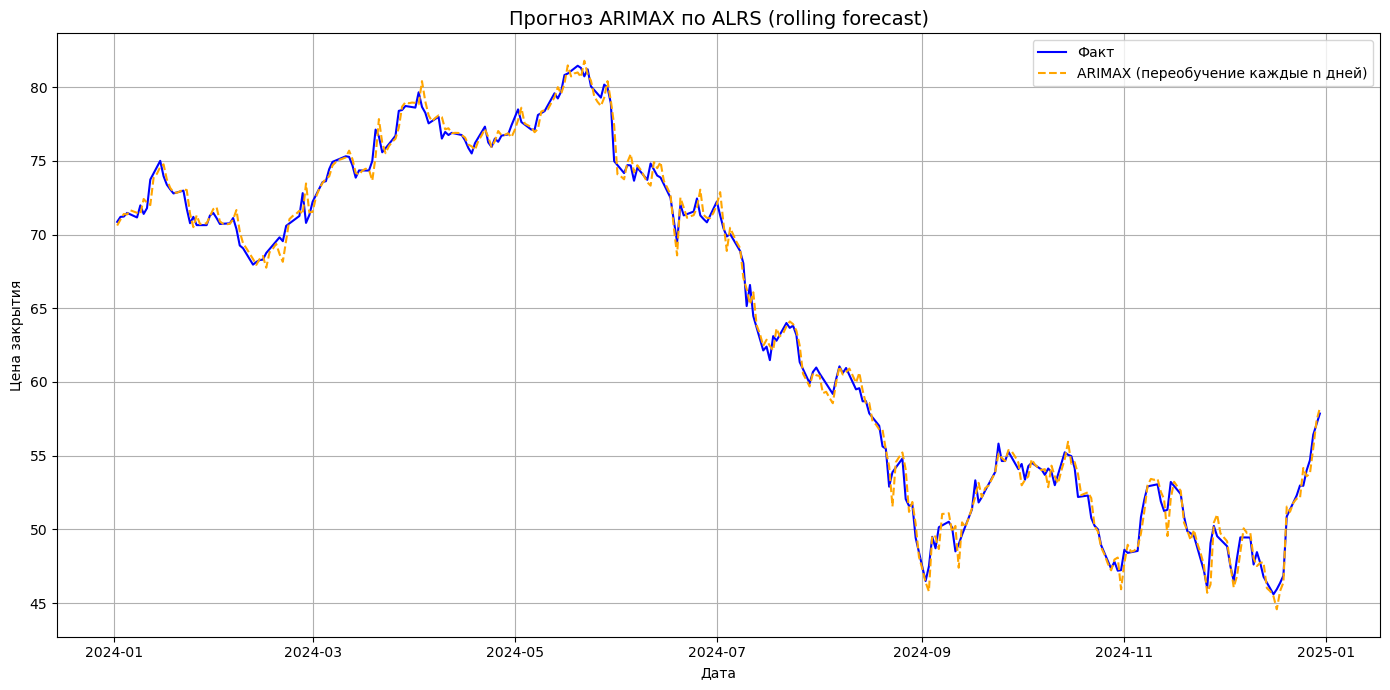

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm import tqdm
import time
import warnings

warnings.filterwarnings('ignore')

# === Загрузка данных ===
df = pd.read_csv("C:/Users/Matvey/Desktop/Диплом/alrs_merged_data.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]  # Удаляем константы

# === Экзогенные переменные ===
target = "Stock Close"
best_features = ["IMOEX Close", "MOEXOG Close", "CNY Rate"]
best_features = [f for f in best_features if f in df.columns]

# === Обработка пропусков ===
df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

# === Определение фиксированных лагов через тест Грейнджера ===
optimal_lags = {}
for feature in best_features:
    try:
        result = grangercausalitytests(df[[target, feature]].dropna(), maxlag=10, verbose=False)
        p_values = [result[i+1][0]['ssr_ftest'][1] for i in range(10)]
        optimal_lag = np.argmin(p_values) + 1
        optimal_lags[feature] = optimal_lag
    except Exception:
        continue

# === Создание лагов (раз и навсегда) ===
def create_lags(data, lags_dict):
    data_copy = data.copy()
    for feature, lag in lags_dict.items():
        for l in range(1, lag + 1):
            data_copy[f'{feature}_lag{l}'] = data_copy[feature].shift(l)
    return data_copy.dropna()

df_lagged = create_lags(df, optimal_lags)

# === Деление на train/test ===
split_idx = int(len(df_lagged) * 0.75)
train_lagged = df_lagged.iloc[:split_idx]
test_lagged = df_lagged.iloc[split_idx:]

y_train = train_lagged[target]
X_train = train_lagged.drop(columns=[target])
y_test = test_lagged[target]
X_test = test_lagged.drop(columns=[target])

# === Rolling прогноз с переобучением ARIMAX ===
forecast_list = []
n_days = min(optimal_lags.values())

print("🔄 Rolling forecast начат...")
start_time = time.time()

for i in tqdm(range(0, len(X_test), n_days), desc="Прогнозирование", unit="шаг"):
    end_i = min(i + n_days, len(X_test))
    if end_i <= i:
        break

    current_y_train = pd.concat([y_train, y_test.iloc[:i]])
    current_X_train = pd.concat([X_train, X_test.iloc[:i]])
    current_X_forecast = X_test.iloc[i:end_i]

    print(f"📍 Итерация {i}-{end_i} | Дата: {y_test.index[i].date()}")

    optimal_arima = auto_arima(current_y_train, exogenous=current_X_train, seasonal=False, d=1,
                               trace=False, stepwise=True, suppress_warnings=True, max_p=3, max_q=3)

    model = SARIMAX(current_y_train, exog=current_X_train, order=optimal_arima.order)
    model_fit = model.fit(maxiter=500, disp=False)

    steps_ahead = len(current_X_forecast)
    preds = model_fit.forecast(steps=steps_ahead, exog=current_X_forecast)
    forecast_list.extend(preds)

elapsed_time = time.time() - start_time
print(f"✅ Rolling прогноз завершён за {elapsed_time:.1f} секунд.")

# === Сбор результатов ===
forecast_df = pd.DataFrame({
    'Date': y_test.index[:len(forecast_list)],
    'Actual Stock Close': y_test.values[:len(forecast_list)],
    'Forecast Stock Close': forecast_list
}).set_index('Date')

# === Метрики качества ===
mae = mean_absolute_error(forecast_df['Actual Stock Close'], forecast_df['Forecast Stock Close'])
rmse = np.sqrt(mean_squared_error(forecast_df['Actual Stock Close'], forecast_df['Forecast Stock Close']))
mape = np.mean(np.abs((forecast_df['Actual Stock Close'] - forecast_df['Forecast Stock Close']) / forecast_df['Actual Stock Close'])) * 100

print(f"\n📊 Оценка качества прогноза по ALRS:")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"MAPE = {mape:.2f}%")

# === Визуализация прогноза ===
plt.figure(figsize=(14, 7))
plt.plot(forecast_df.index, forecast_df['Actual Stock Close'], label='Факт', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast Stock Close'], label='ARIMAX (переобучение каждые n дней)', color='orange', linestyle='--')
plt.title('Прогноз ARIMAX по ALRS (rolling forecast)', fontsize=14)
plt.xlabel('Дата')
plt.ylabel('Цена закрытия')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


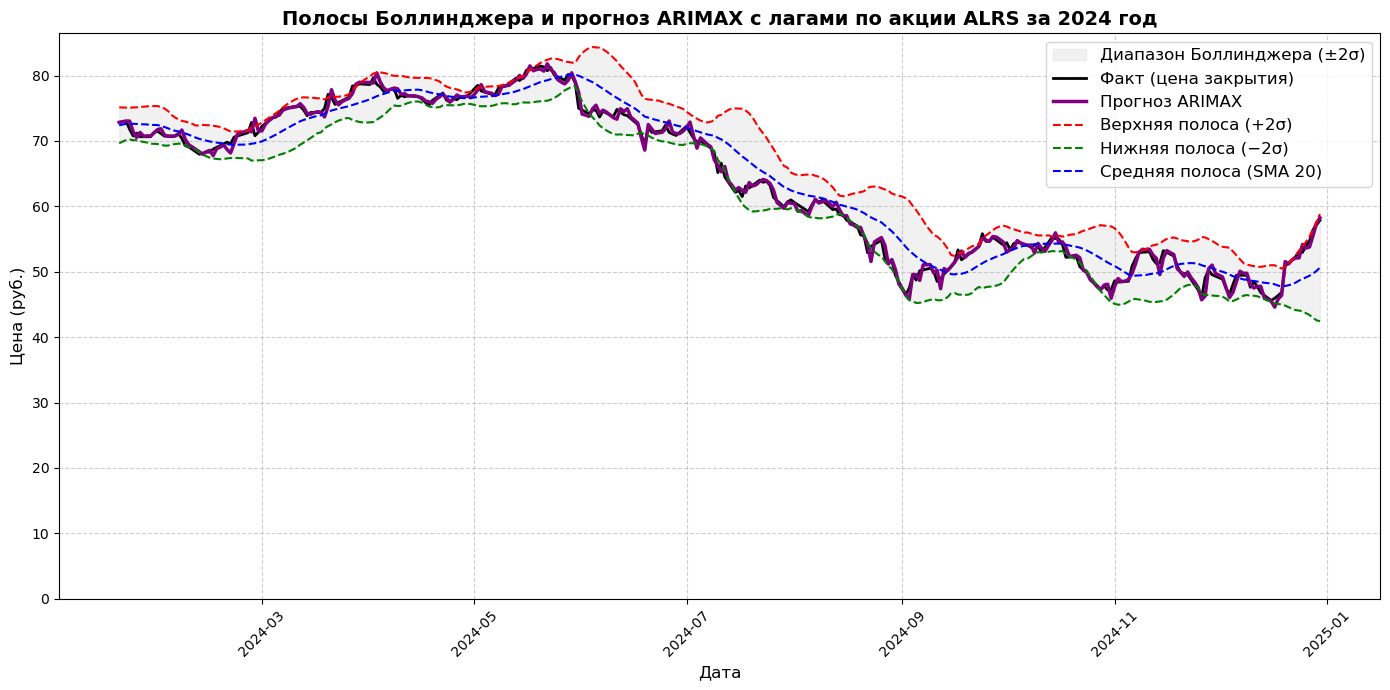

In [14]:
# === Полосы Боллинджера и прогноз ARIMAX с лагами (2024 год) ===

# Отбор данных за 2024 год
df_boll = df.loc["2024-01-01":"2024-12-31"].copy()
df_boll["close"] = df_boll["Stock Close"]

# Расчёт полос Боллинджера
df_boll["bollinger_mid"] = df_boll["close"].rolling(window=20).mean()
df_boll["bollinger_std"] = df_boll["close"].rolling(window=20).std()
df_boll["bollinger_upper"] = df_boll["bollinger_mid"] + 2 * df_boll["bollinger_std"]
df_boll["bollinger_lower"] = df_boll["bollinger_mid"] - 2 * df_boll["bollinger_std"]
df_boll.dropna(subset=["bollinger_upper", "bollinger_lower"], inplace=True)

# Прогноз ARIMAX как Series
forecast_series = forecast_df["Forecast Stock Close"]

# Общий индекс для визуализации
common_index = df_boll.index.intersection(forecast_series.index)

# Подготовка данных
forecast_for_boll = forecast_series.loc[common_index]
actual_for_boll = forecast_df["Actual Stock Close"].loc[common_index]
upper = df_boll["bollinger_upper"].loc[common_index]
lower = df_boll["bollinger_lower"].loc[common_index]
mid = df_boll["bollinger_mid"].loc[common_index]

# === Визуализация ===
plt.figure(figsize=(14, 7))

# Диапазон Боллинджера
plt.fill_between(common_index, lower, upper, color="lightgray", alpha=0.3, label="Диапазон Боллинджера (±2σ)")

# Фактическая цена
plt.plot(actual_for_boll.index, actual_for_boll, label="Факт (цена закрытия)", color="black", linewidth=2)

# Прогноз ARIMAX
plt.plot(forecast_for_boll.index, forecast_for_boll, label="Прогноз ARIMAX", color="purple", linewidth=2.5)

# Полосы
plt.plot(upper.index, upper, label="Верхняя полоса (+2σ)", color="red", linestyle="--", linewidth=1.5)
plt.plot(lower.index, lower, label="Нижняя полоса (−2σ)", color="green", linestyle="--", linewidth=1.5)
plt.plot(mid.index, mid, label="Средняя полоса (SMA 20)", color="blue", linestyle="--", linewidth=1.5)

# Оформление
plt.title("Полосы Боллинджера и прогноз ARIMAX с лагами по акции ALRS за 2024 год", fontsize=14, fontweight="bold")
plt.xlabel("Дата", fontsize=12)
plt.ylabel("Цена (руб.)", fontsize=12)
plt.ylim(bottom=0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
